In [1]:
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
import shapely.geometry
import matplotlib.pyplot as plt

In [2]:
# Colormap from https://www.nature.com/articles/s41592-023-01974-0
# Available at https://scottplot.net/cookbook/4.1/colors/#category-10
sns.set_palette(['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7'])
sns.color_palette(['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7'])

[(0.0, 0.0, 0.0),
 (0.9019607843137255, 0.6235294117647059, 0.0),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.0, 0.4470588235294118, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137)]

# Goodness of Fit (GoF) metric

**Obs:** This script shows how the Goodness of Fit (GoF) metric can be estimated, based on some example data from turbidity algorithm performance for Patos Lagoon (Brazil). GoF summarizes multiple statistical parameters allowing a more objective performance classification. It is based on radar plots and estimated by the product of the plot area and the distance between the centroid and plot center.

## Defining Functions

In [3]:
def normalize(x, col):
    
    # Max and min values for normalization
    norm_dict = {'Kendall':[0,1], 'MAE':[0, 60], 'MAPE':[0,8], 'Bias':[0, 60], 'WR':[0, 100], 'GoF':[0, 150]}
    min_value, max_value = norm_dict[col]
    
    # Absolute Bias value
    if col=='Bias':
        x[col] = x[col].abs()
        
    # Normalization (between 0 and 1)
    if col=='Kendall' or col=='WR':
        norm = 1 - ((x[col] - min_value)/(max_value - min_value))
    else:
        norm = (x[col] - min_value)/(max_value - min_value)
    
    # Results are normalized between 0 and 10
    norm = norm*10
    
    return norm

In [4]:
def GoF(df):
    
    from math import pi
    import shapely.geometry

    # Final df
    final_df = df.copy()
    
    # Variables
    categories = ['Kendall', 'MAE', 'MAPE', 'Bias', 'WR']
    N = len(categories)

    # Angle of each axis (plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Normalizing values
    for col in categories:
        df[col] = normalize(df, col)

    # Estimating GoF
    i = 0
    for index in df.index:
        
                values=df.loc[index, categories].values.flatten().tolist()
                values += values[:1]

                # Area and centroid distance estimation
                polygon = pd.DataFrame(zip(categories, angles[:-1], values[:-1]), columns=['categories', 'theta', 'r'])
                polygon["x"] = np.cos(polygon["theta"]) * polygon["r"]
                polygon["y"] = np.sin(polygon["theta"]) * polygon["r"]
                geom = shapely.geometry.MultiPoint(polygon[['x', 'y']].to_numpy()).convex_hull 
                area = geom.area
                centroid = np.array(geom.centroid.coords)[0]
                dist = np.sqrt(centroid[0]**2 + centroid[1]**2) # as coordenadas do centro são (0, 0)
                volume = area*dist
                
                final_df.loc[index, 'area'] = np.round(area, 2)
                final_df.loc[index, 'dist'] = np.round(dist, 2)
                final_df.loc[index, 'GoF'] = np.round(volume, 2)
                
    return final_df

## Input data

In [5]:
# Turbidity algorithms performance for Patos Lagoon
input_data = pd.read_csv('../Dados/example_data.csv', dtype={'Band':str}, index_col=['Sat', 'AC', 'Alg', 'Band']) 

In [6]:
input_data

n  Kendall  p-value   RMSE    MAE  MAPE   Bias     WR
Sat AC      Alg Band                                                         
L8  Acolite D15 NaN    40     0.74      0.0  23.84  13.81  1.10  12.60  43.73
            N09 655    48     0.73      0.0  15.20  10.71  0.95   0.09  38.22
                865    37     0.53      0.0  14.78  10.47  1.89   9.05  37.30
    Polymer D15 NaN    46     0.67      0.0  24.13  12.83  0.43 -12.55  60.02
            N09 655    46     0.67      0.0  24.02  12.63  0.42 -12.29  72.63
                865    46     0.71      0.0  23.11  12.96  0.50 -12.83  48.11
S2  Acolite D15 NaN   198     0.69      0.0  30.72  18.91  1.03  16.29  31.16
            N09 665   209     0.69      0.0  15.40  10.66  0.86   3.47  41.58
                865   184     0.51      0.0  20.15  15.47  2.03  12.47  32.35
    Polymer D15 NaN   207     0.61      0.0  23.03  11.07  0.38  -9.27  65.96
            N09 665   207     0.60      0.0  22.84  11.13  0.44  -7.89  64.56
                865   189     0.70      0.0  23.79  12.08  0.32 -11.60  64.40
S3  Acolite D15 NaN   219     0.59      0.0  40.16  15.26  0.76  -0.65  37.94
            N09 665   346     0.65      0.0  31.01  13.03  0.72   0.22  29.38
                865   103     0.43      0.0  45.27  19.33  1.04  -4.31  55.80
    Polymer D15 NaN   267     0.65      0.0  36.31  11.23  0.30  -9.80  60.97
            N09 665   271     0.65      0.0  35.88  11.81  0.39  -8.65  54.89
                865   242     0.70      0.0  37.20  11.79  0.27 -11.20  61.03

## Estimating GoF

In [7]:
# GoF
input_data = GoF(input_data)

In [8]:
input_data # new dataframe, with plot area, centroid distance and GoF

n  Kendall  p-value   RMSE    MAE  MAPE   Bias     WR   
Sat AC      Alg Band                                                            
L8  Acolite D15 NaN    40     0.74      0.0  23.84  13.81  1.10  12.60  43.73  \
            N09 655    48     0.73      0.0  15.20  10.71  0.95   0.09  38.22   
                865    37     0.53      0.0  14.78  10.47  1.89   9.05  37.30   
    Polymer D15 NaN    46     0.67      0.0  24.13  12.83  0.43 -12.55  60.02   
            N09 655    46     0.67      0.0  24.02  12.63  0.42 -12.29  72.63   
                865    46     0.71      0.0  23.11  12.96  0.50 -12.83  48.11   
S2  Acolite D15 NaN   198     0.69      0.0  30.72  18.91  1.03  16.29  31.16   
            N09 665   209     0.69      0.0  15.40  10.66  0.86   3.47  41.58   
                865   184     0.51      0.0  20.15  15.47  2.03  12.47  32.35   
    Polymer D15 NaN   207     0.61      0.0  23.03  11.07  0.38  -9.27  65.96   
            N09 665   207     0.60      0.0  22.84  11.13  0.44  -7.89  64.56   
                865   189     0.70      0.0  23.79  12.08  0.32 -11.60  64.40   
S3  Acolite D15 NaN   219     0.59      0.0  40.16  15.26  0.76  -0.65  37.94   
            N09 665   346     0.65      0.0  31.01  13.03  0.72   0.22  29.38   
                865   103     0.43      0.0  45.27  19.33  1.04  -4.31  55.80   
    Polymer D15 NaN   267     0.65      0.0  36.31  11.23  0.30  -9.80  60.97   
            N09 665   271     0.65      0.0  35.88  11.81  0.39  -8.65  54.89   
                865   242     0.70      0.0  37.20  11.79  0.27 -11.20  61.03   

                       area  dist    GoF  
Sat AC      Alg Band                      
L8  Acolite D15 NaN   18.30  1.33  24.40  
            N09 655   13.39  1.71  22.93  
                865   26.07  1.90  49.47  
    Polymer D15 NaN   14.92  1.18  17.58  
            N09 655   11.53  0.89  10.22  
                865   16.77  1.45  24.39  
S2  Acolite D15 NaN   27.27  1.66  45.34  
            N09 665   14.04  1.75  24.51  
                865   34.08  1.79  61.04  
    Polymer D15 NaN   13.07  1.31  17.16  
            N09 665   13.31  1.40  18.64  
                865   12.37  1.04  12.80  
S3  Acolite D15 NaN   19.94  1.98  39.54  
            N09 665   18.17  2.14  38.94  
                865   24.66  1.96  48.42  
    Polymer D15 NaN   13.54  1.30  17.67  
            N09 665   14.71  1.47  21.69  
                865   12.90  1.14  14.76

## Radar Plots

In [9]:
# Cartesian coordinates to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

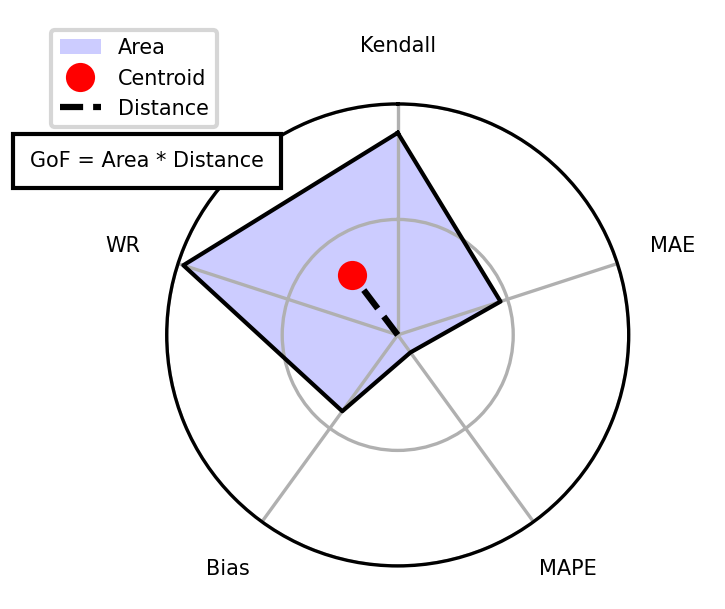

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), sharex=True, sharey=True, subplot_kw={'polar':True}, dpi=300)
#ax = ax.flatten()

df = input_data.iloc[[15]].copy() # random dataframe row

# Variables
categories = ['Kendall', 'MAE', 'MAPE', 'Bias', 'WR']
N = len(categories)

# Angle of each axis (plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Normalizing values
for col in categories:
        df[col] = normalize(df, col)

# Plot  
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1], categories, color='k', size=5)
ax.set_rlabel_position(0)
ticks=np.linspace(0,10,6)
ax.set_yticks(ticks, [])
ax.set_ylim(0,4)

values=df[categories].values.flatten().tolist()
values += values[:1]
            
# Area estimation
polygon = pd.DataFrame(zip(categories, angles[:-1], values[:-1]), columns=['categories', 'theta', 'r'])
polygon["x"] = np.cos(polygon["theta"]) * polygon["r"]
polygon["y"] = np.sin(polygon["theta"]) * polygon["r"]
polygon['alg'] = 'dummy'
area = polygon.groupby("alg").apply(lambda d: shapely.geometry.MultiPoint(list(zip(d["x"], d["y"]))).convex_hull.area)
centroid = polygon.groupby("alg").apply(lambda d: shapely.geometry.MultiPoint(list(zip(d["x"], d["y"]))).convex_hull.centroid)
centroid = np.array(centroid.iloc[0].coords)[0]
centroid_value, centroid_angle = cart2pol(centroid[0], centroid[1])
            
# Plot
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.2,  label='Area')
ax.plot(centroid_angle, centroid_value, 'ro', label='Centroid', zorder=10)
ax.plot([0,centroid_angle], [0, centroid_value], 'k--', label='Distance', zorder=5)

ax.legend(loc=(-0.25,0.95), fontsize=5)
ax.text(-pi/2.75, 7, 'GoF = Area * Distance', bbox={'edgecolor':'k', 'fill':True, 'facecolor':'w'}, fontsize=5)


# Show the plot
plt.show()

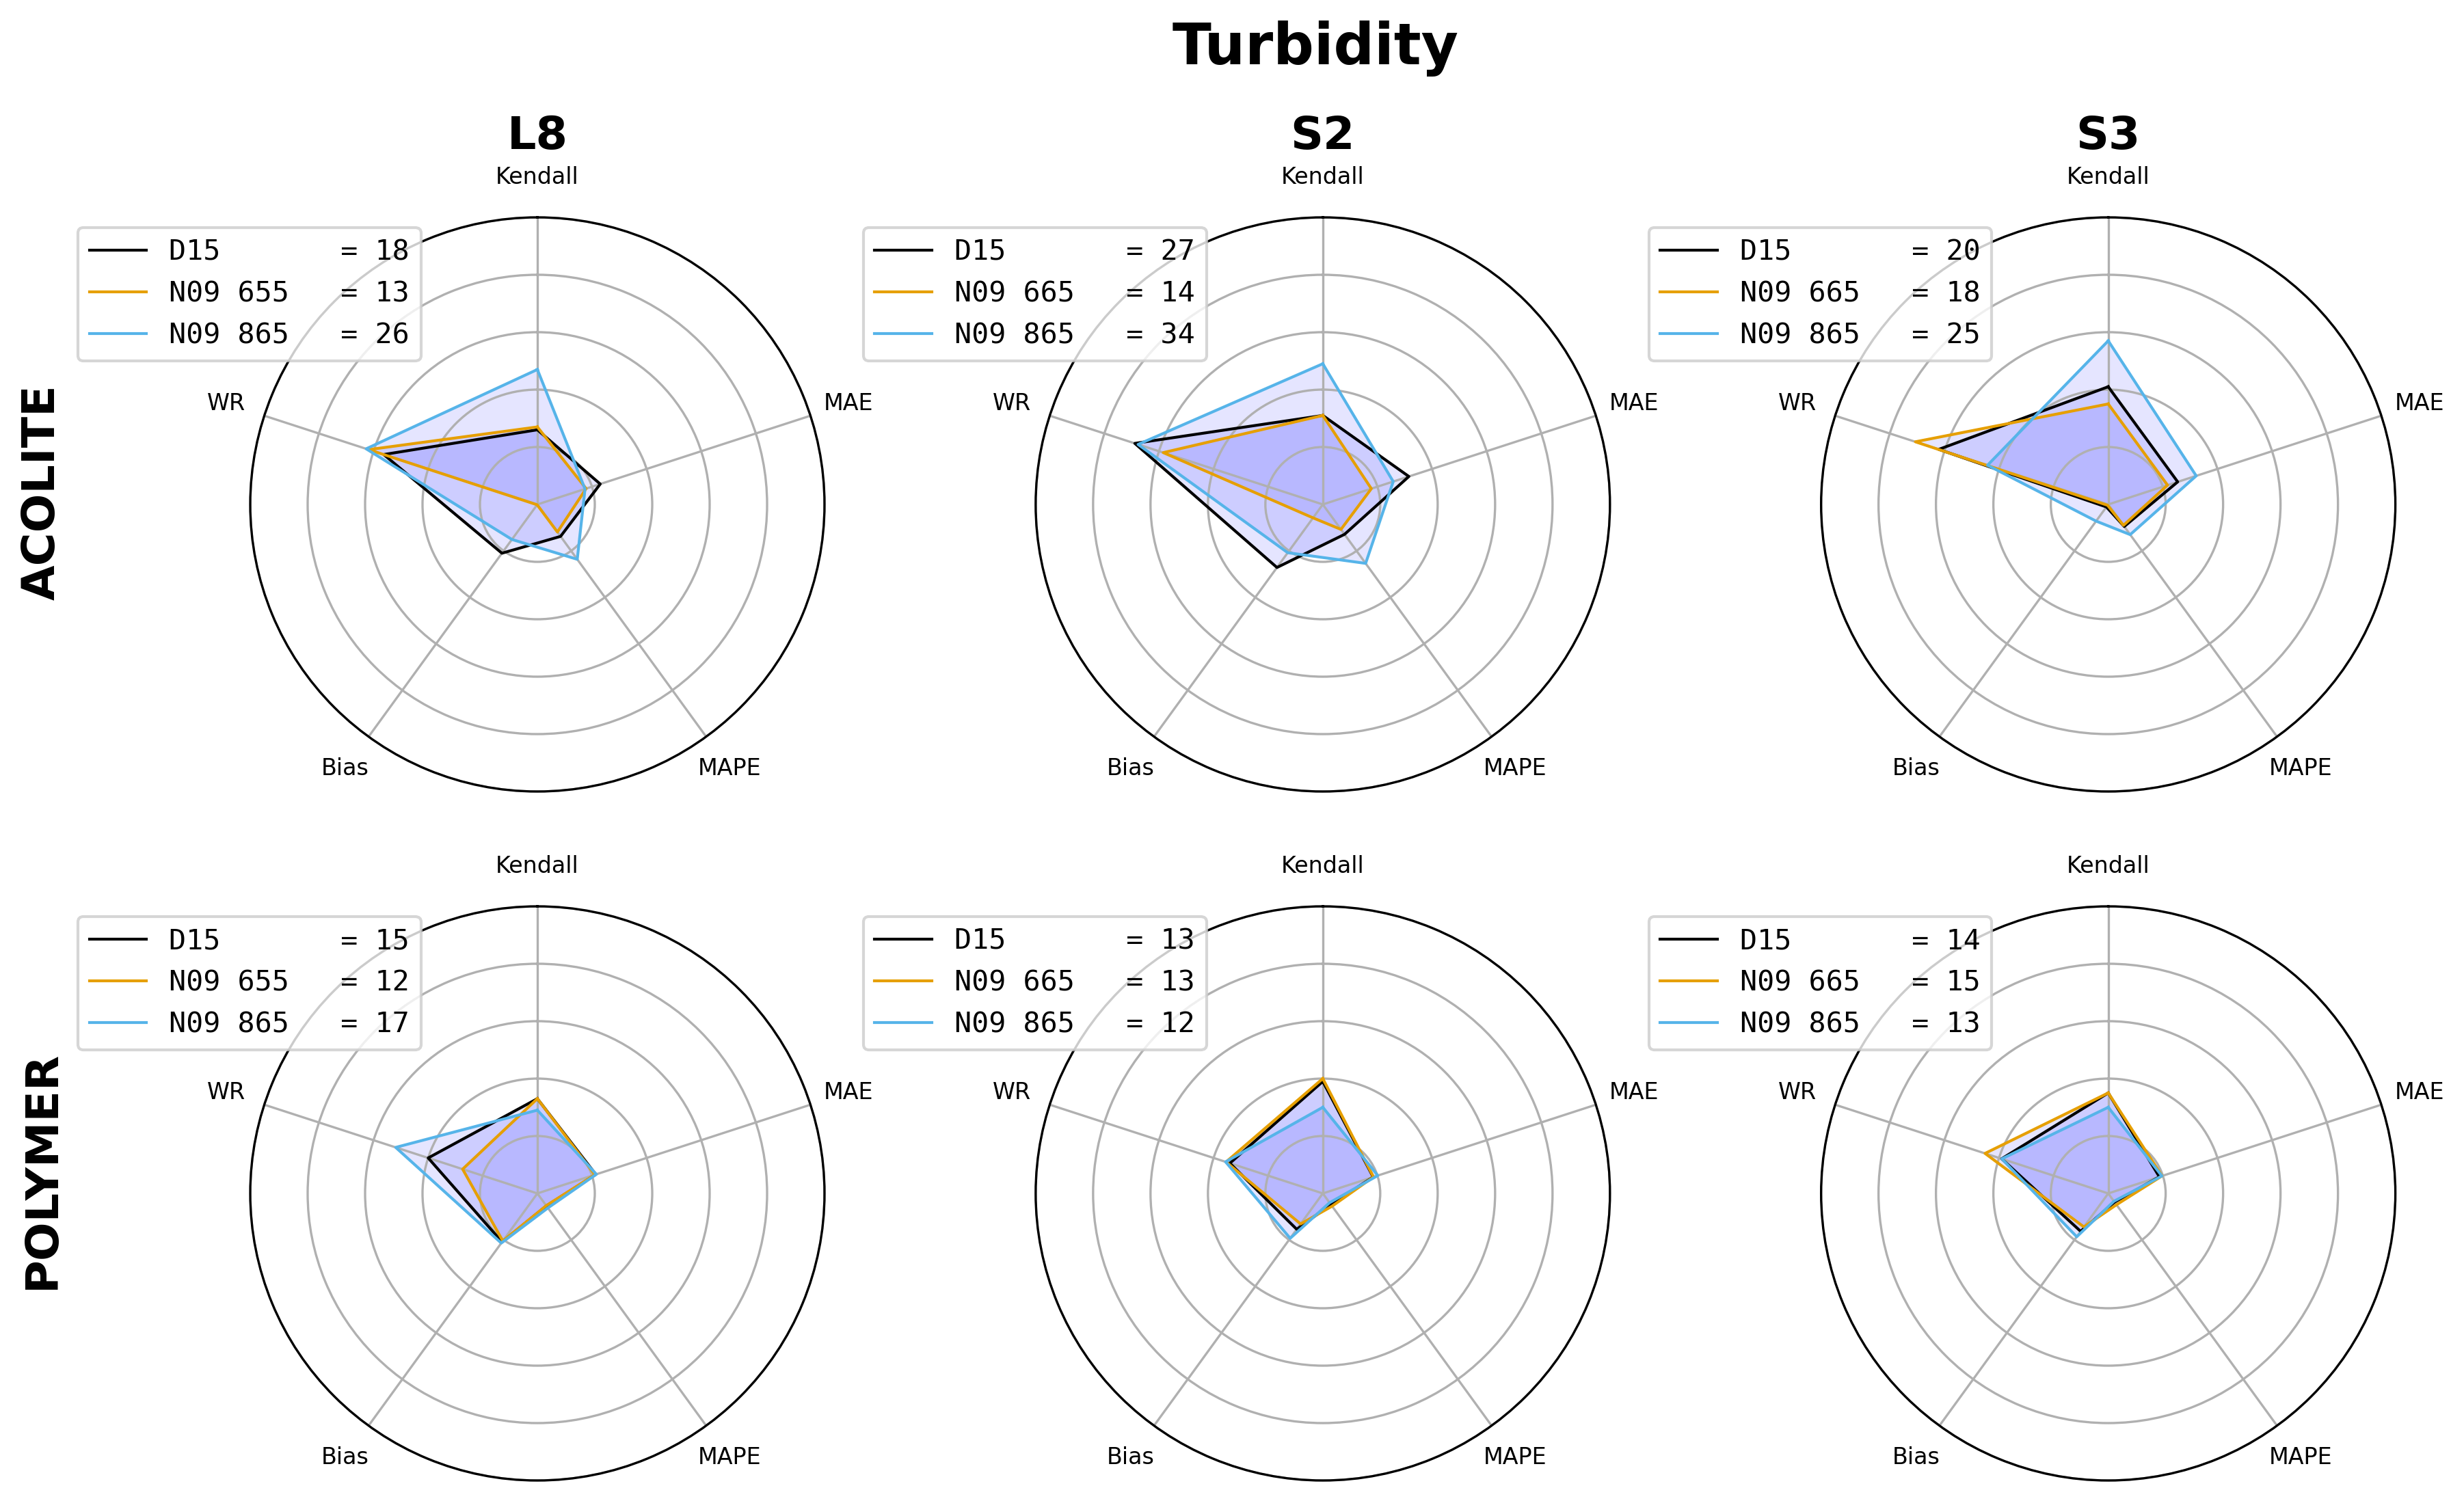

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8), sharex=True, sharey=True, subplot_kw={'polar':True}, dpi=300)
ax = ax.flatten()

df = input_data.loc[:,:,['N09', 'D15']].copy()

# Variables
categories = ['Kendall', 'MAE', 'MAPE', 'Bias', 'WR']
N = len(categories)

# Angle of each axis (plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Normalizing values
for col in categories:
    df[col] = normalize(df, col)

# Plot
i = 0
for ac in ['Acolite', 'Polymer']:
    for sat in ['L8', 'S2', 'S3']:
    
        ax[i].set_theta_offset(pi / 2)
        ax[i].set_theta_direction(-1)
        ax[i].set_xticks(angles[:-1], categories, color='k', size=8)
        ax[i].set_rlabel_position(0)
        ticks=np.linspace(0,10,6)
        ax[i].set_yticks(ticks, [])
        ax[i].set_ylim(0,10)

        # Plot data
        for index in df.loc[sat,ac,['D15', 'N09']].index:
            label = '_'.join([i for i in index if type(i)!=float][2:])    
            values=df.loc[index, categories].values.flatten().tolist()
            values += values[:1]
            
            # Area estimation
            polygon = pd.DataFrame(zip(categories, angles[:-1], values[:-1]), columns=['categories', 'theta', 'r'])
            polygon["x"] = np.cos(polygon["theta"]) * polygon["r"]
            polygon["y"] = np.sin(polygon["theta"]) * polygon["r"]
            polygon['alg'] = label
            area = polygon.groupby("alg").apply(lambda d: shapely.geometry.MultiPoint(list(zip(d["x"], d["y"]))).convex_hull.area)
            label=' '.join(label.upper().split('_'))
            label = '{:<9} = {:.0f}'.format(label, area.to_list()[0])
            
            # Plot
            ax[i].plot(angles, values, linewidth=1, linestyle='solid', label=label)
            ax[i].fill(angles, values, 'b', alpha=0.1)
            ax[i].legend(loc=[-0.30,0.75], prop={'family': 'DejaVu Sans Mono'})

        i+=1

plt.suptitle('Turbidity', size=20, weight='bold', x=0.51, y=1)
ax[0].annotate('ACOLITE', xy=(-0.4,0.35), size=16, weight='bold', xycoords='axes fraction', rotation=90)
ax[3].annotate('POLYMER', xy=(-0.4,0.35), size=16, weight='bold', xycoords='axes fraction', rotation=90)
for i, sat in zip(range(3), ['L8', 'S2', 'S3']):
    ax[i].set_title(sat, size=16, weight='bold') 

# Show the plot
plt.show()